In [1]:
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [14]:
import os
fname = os.listdir("camera_cal/")

['calibration1.jpg',
 'calibration10.jpg',
 'calibration11.jpg',
 'calibration12.jpg',
 'calibration13.jpg',
 'calibration14.jpg',
 'calibration15.jpg',
 'calibration16.jpg',
 'calibration17.jpg',
 'calibration18.jpg',
 'calibration19.jpg',
 'calibration2.jpg',
 'calibration20.jpg',
 'calibration3.jpg',
 'calibration4.jpg',
 'calibration5.jpg',
 'calibration6.jpg',
 'calibration7.jpg',
 'calibration8.jpg',
 'calibration9.jpg']

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


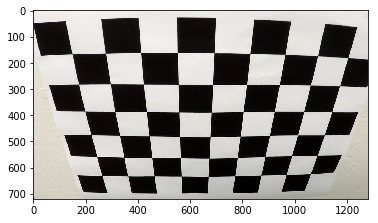

In [2]:
#reading in an image
theImage = mpimg.imread('camera_cal\calibration2.jpg')

#printing out some stats and plotting
print('This image is:', type(theImage), 'with dimensions:', theImage.shape)
plt.imshow(theImage)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

Step 1 - Set ChessBoard size to 9x6 and Calibrate Camera

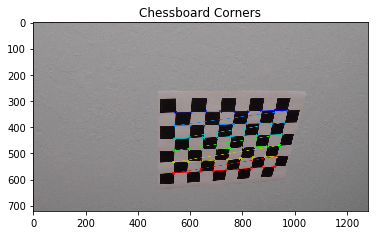

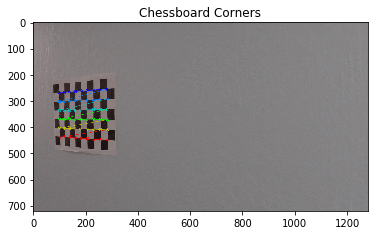

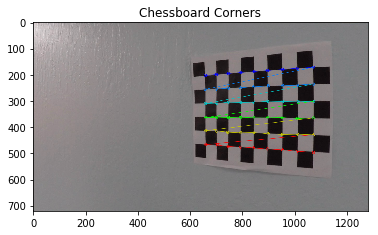

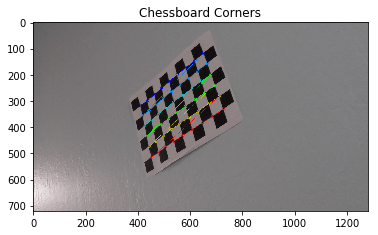

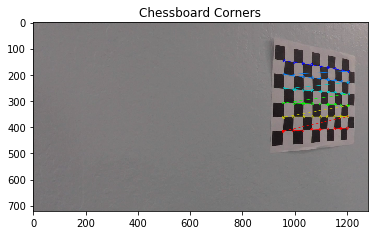

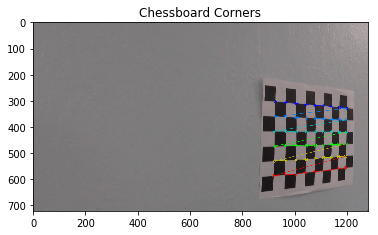

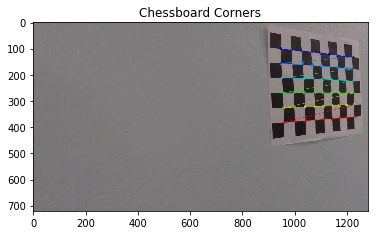

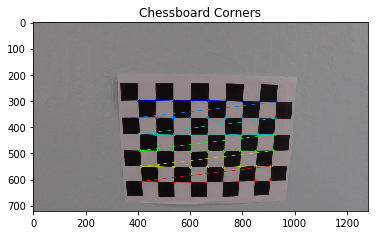

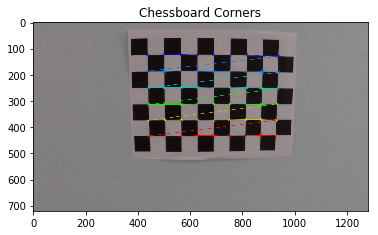

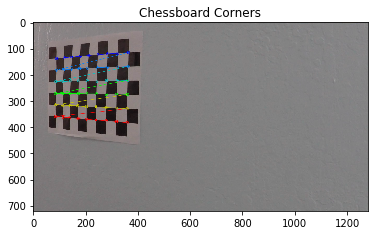

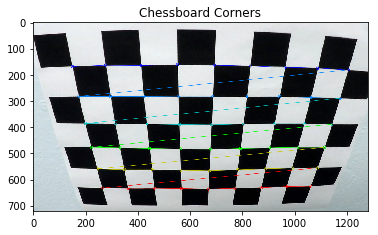

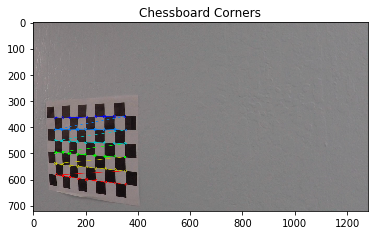

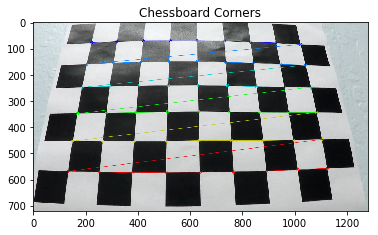

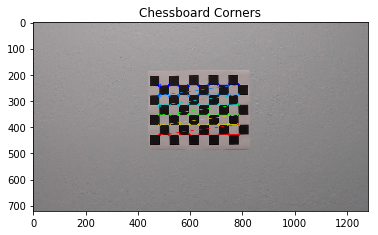

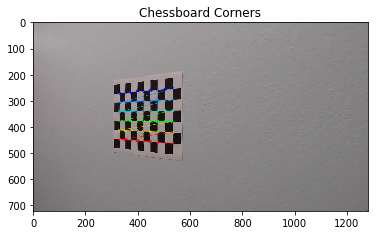

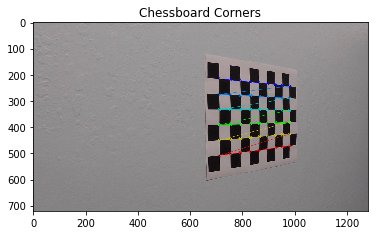

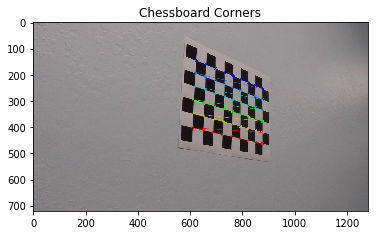

In [2]:
# prepare object points
nx = 9 #TODO: enter the number of inside corners in x
ny = 6 #TODO: enter the number of inside corners in y


# Make a list of calibration images
#fname = 'camera_cal\calibration2.jpg' #Test file aquisition
#img = cv2.imread(fname) #Test file aquisition

#Create an array filled with point locations were representing where the corners should be on a chessboard. 
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

#Create empty arrays to store image points from computer vision analysis and object points 
objpoints = []
imgpoints = []

Images = glob.glob('camera_cal\*.jpg')

for Image in Images:
    #Read in an image to calibrate
    img = cv2.imread(Image)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(img, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        #store object points and image points to do an image correction in the future.
        objpoints.append(objp)
        imgpoints.append(corners)
        
        
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        plt.title('Chessboard Corners')
        plt.show()

plt.imsave('output_images/1', img)


Step 2 - Undistort Images

In [3]:
# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def camera_cal(pic, THEobjpoints, THEimgpoints):
    # Use cv2.calibrateCamera()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(THEobjpoints, THEimgpoints, pic.shape[0:2], None, None)
    return mtx, dist

def cal_undistort(image, mtx, dist):
    #img = cv2.imread(image)
    
    undistort = cv2.undistort(image, mtx, dist, None, mtx)
    return undistort     

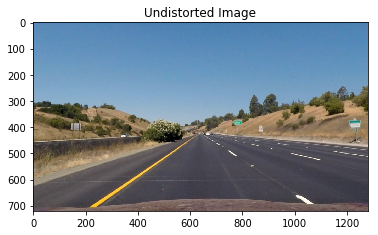

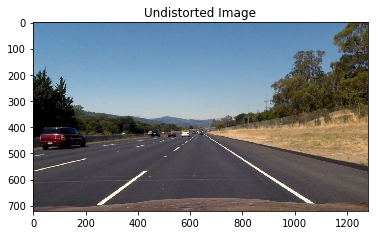

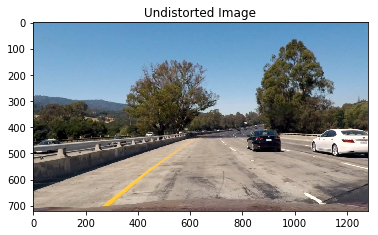

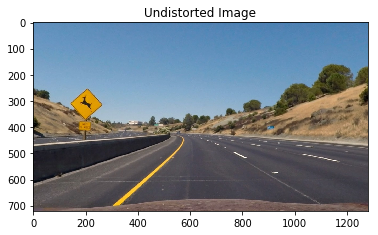

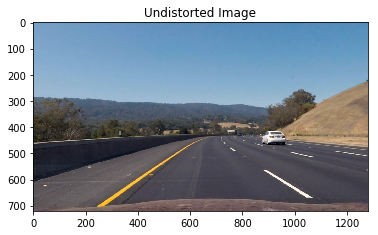

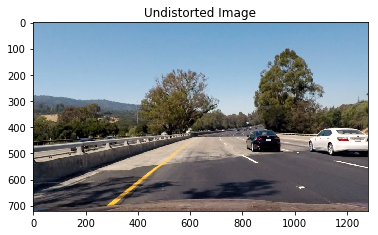

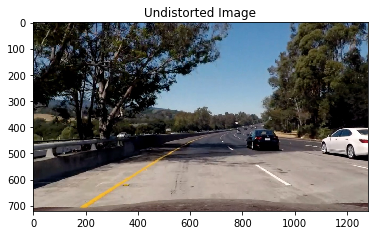

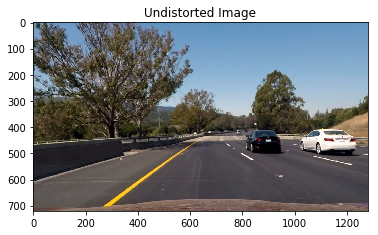

In [4]:
cal_matrices = []
Distorted = []
counter = 0
while counter < len(Images):
    photo = cv2.imread(Images[counter])
    cal_matrix, distort = camera_cal(photo, objpoints, imgpoints)
    cal_matrices.append(cal_matrix)
    Distorted.append(distort)
    counter += 1
    

Folder = glob.glob('test_images/*.jpg')
Undistorted = []

i = 0
while i < len(Folder):
    
    PIC = cv2.imread(Folder[i])
    fresh_Img = cv2.cvtColor(PIC,cv2.COLOR_BGR2RGB)
    distort = Distorted[i]
    cal_matrix = cal_matrices[i]
    undistort = cal_undistort(fresh_Img, cal_matrix, distort) #TEST CALIBRATION
    Undistorted.append(undistort)
    plt.imshow(undistort)
    plt.title('Undistorted Image')
    plt.show()
    i += 1
    
plt.imsave('output_images/2', undistort)

Step 3 - Perspective Transform

In [36]:
#Function to perform Perspective Transform
#Takes in an img, chessboard size, camera matrix, and distorted coefficients
def warp(img):
    #Create lane corners to use in perspective transform
    #src
    bottom_left = [225,720] 
    bottom_right = [1105, 720]
    top_left = [570, 470]
    top_right = [712, 470]

    corners=[]
    corners.append(top_left)
    corners.append(top_right)
    corners.append(bottom_right)
    corners.append(bottom_left)
    
    #dst
    top_left_dst = [320,0] # [340,0]
    top_right_dst = [980,0] # [990,0]
    bottom_left_dst = [320,720]
    bottom_right_dst = [980,720]
    # Pass in your image into this function
    # offset for dst points
    offset = 10 
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
        
    # a) define 4 source points src = np.float32([[,],[,],[,],[,]])
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
        
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
    # b) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([top_left_dst, top_right_dst, bottom_right_dst, bottom_left_dst])
    
    # c) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # d) use this to get inverse matrix to transform image back
    Minv = cv2.getPerspectiveTransform(dst, src)
        
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

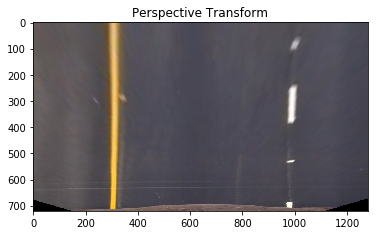

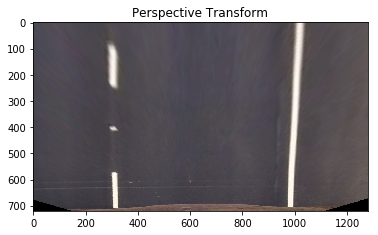

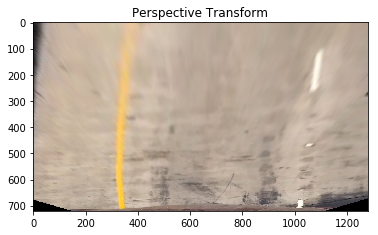

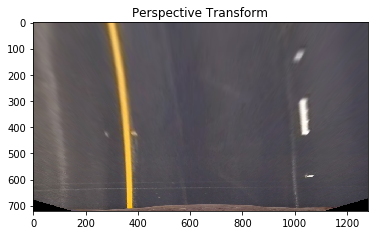

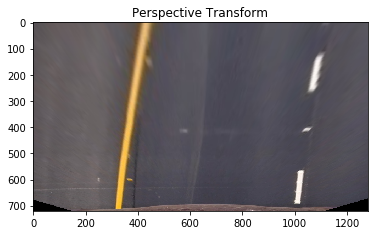

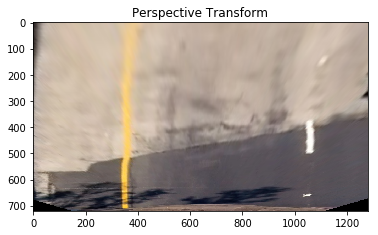

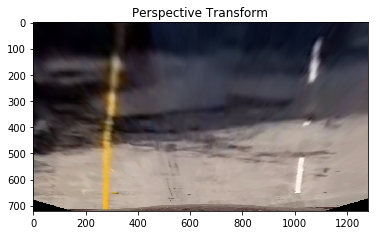

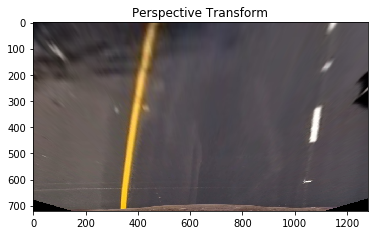

In [37]:
perspect_Image = []
Minv = []
for item in Undistorted:
    new_Image, Minv = warp(item)
    hsvImage = cv2.cvtColor(new_Image, cv2.COLOR_RGB2HSV)
    hlsImage = cv2.cvtColor(new_Image, cv2.COLOR_RGB2HLS)
    perspect_Image.append(new_Image)
    plt.imshow(new_Image)
    #plt.imshow(hsvImage[:,:,2])# v
    #plt.imshow(hsvImage[:,:,1])# s
    #plt.imshow(hlsImage[:,:,2])# S
    #plt.imshow(hlsImage[:,:,1])# l

    
    plt.title('Perspective Transform')
    plt.show()
    
    
plt.imsave('output_images/3', new_Image)


Step 4 - Color Gradient Threshold Functions

In [7]:
#Perform a direct threshold on the image
def dir_threshold(image, sobel_kernel=3, thresh=(210, 255)):#207
    
    #Convert image to grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #Return mask as binary
    binary_output = np.zeros_like(gray)
    binary_output[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    
    return binary_output

In [8]:
#Function that takes an image as input and analyzes the R portion of RGB color img.  
#This is done to determine where the yellow lane lines are,
#then applies a threshold to eliminate unnecessary data in the img.
def threshold_Red(image, sobel_kernel=3, thresh=(225, 255)):
    
    #Filter the image for just the red value of the RGB image
    R = image[:,:,0]
    binary_output = np.zeros_like(R)
    binary_output[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    return binary_output

In [9]:
#Function that takes an image as input and analyzes the R portion of RGB color img.  
#This is done to determine where the yellow lane lines are,
#then applies a threshold to eliminate unnecessary data in the img.
def threshold_Green(image, sobel_kernel=3, thresh=(207, 255)):
    
    #Filter the image for just the red value of the RGB image
    G = image[:,:,1]
    binary_output = np.zeros_like(G)
    binary_output[(G > thresh[0]) & (G <= thresh[1])] = 1
    
    return binary_output

In [10]:
# function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=30, thresh_max=100):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = 255*abs_sobel/np.max(abs_sobel)
    #scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
            
    sxbinary_output = np.zeros_like(scaled_sobel)
    sxbinary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
     
    # 6) Return this mask as your binary_output image
    return sxbinary_output

In [11]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 150)): #10 , 100
    
    # Apply the following steps to img
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 1)Take the gradient in x and y separately
    x_grad = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    y_grad = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Calculate the magnitude 
    mag = np.sqrt(x_grad**2 + y_grad**2)
    # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(mag)/255 
    # 4) Create a binary mask where mag thresholds are met
    mag = (mag/scale_factor).astype(np.uint8)
    # 5) Return this mask as your binary_output image
    binary_output = np.zeros_like(mag)
    binary_output[(mag >= mag_thresh[0]) & (mag <= mag_thresh[1])] = 1
    #return output
    return binary_output    

In [12]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def s_select(img, thresh=(110, 254)):
    # 1) Convert to HLS color space
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = HLS[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

#Test HLS threshold    
#hls_binary = hls_select(image, thresh=(0, 255))

In [13]:
# Define a function that thresholds the h-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def h_select(img, thresh=(18, 100)): # 15 to 100
    # 1) Convert to HLS color space
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    h_channel = HLS[:,:,0]
    binary_output = np.zeros_like(h_channel)
    binary_output[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [14]:
# Define a function that thresholds the l-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def l_select(img, thresh=(215, 255)): # 15 to 100  #150 to 210
    # 1) Convert to HSV color space
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    l_channel = HLS[:,:,1]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [15]:
# Define a function that thresholds the S-channel of HSV
# Use exclusive lower bound (>) and inclusive upper (<=)
def hsv_s(img, thresh=(60, 150)): # 70 to 150
    # 1) Convert to HSV color space
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 2) Apply a threshold to the S channel
    s_channel = HLS[:,:,1]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [16]:
# Define a function that thresholds the S-channel of HSV
# Use exclusive lower bound (>) and inclusive upper (<=)
def hsv_v(img, thresh=(207, 210)): # 70 to 150
    # 1) Convert to HSV color space
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 2) Apply a threshold to the S channel
    v_channel = HLS[:,:,2]
    binary_output = np.zeros_like(v_channel)
    binary_output[(v_channel > thresh[0]) & (v_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [17]:
#combined threshold to identify lane lanes
#Using RGB, HLS, MAGNITUDE X & Y gradient, ABSOLUTE Value X gradient, and a direct threshold from gray image
def combined_threshold(picture, ksize = 7):
    
    #Perform a direct threshold
    dir_binary = dir_threshold(picture)
    #Perfom a Magnitude threshold of x & y gradients
    mag_binary = mag_thresh(picture, sobel_kernel=ksize)
    #Perform a Red threshold from RGB values
    dir_binary_Red = threshold_Red(picture)
    #Perfrom a Green threshold from RGB values
    dir_binary_Green = threshold_Green(picture)
    #Perform a absolute value threshold of the x gradient
    abs_binary = abs_sobel_thresh(picture)
    #Perfrom a threshold from the S component of HLS color space
    hls_S = s_select(picture)
    #Perfrom a threshold from the H component of the HLS color space
    hls_H = h_select(picture)
    #Perfrom a threshold from the H component fo the HLS color space
    hls_L = l_select(picture)
    #Perform a threshold from the S component of the HSV color space
    hsv_S = hsv_s(picture)
    #Perform a threshold from the V component of the HSV color space
    hsv_V = hsv_v(picture)
    #Individual tests to get binary threshold mask working!!!!!!!
    combined = np.zeros_like(dir_binary_Red)
    #Noise levels: minor,small,medium,large
    #combined[(dir_binary == 1)] = 1 #minor noise here!
    #combined[(mag_binary == 1) ] = 1 #small amount of noise here! Misses part of 3,half 6, and half 7
    #combined[(abs_binary == 1) ] = 1 #small noise here! Try to improve image 7 here
    #combined[(hls_S == 1)] = 1 #small amount of noise here! Not picking up much anymore to filter out noise
    #combined[(hls_H == 1)] = 1 #small amount of noise here!
    #combined[(dir_binary_Green == 1) ] = 1 #minor amount of noise here!
    #combined[(dir_binary_Red == 1) ] = 1 #minor amount of noise here!
    #combined[(hls_L == 1) ] = 1 #minor noise
    #combined[(hsv_S == 1) ] = 1
    #combined[(hsv_V == 1) ] = 1
    
    #combined[(hls_S == 1) & (hsv_S == 1)] = 1 #lEFT ONLY FOR ALL BUT 2
    #combined[(hls_S == 1) | (hsv_S == 1)] = 1#BOTH lANES FOR ALL, BUT RIGHT LANES ARE VERY WEAK
    #combined[(hls_S == 1) | (hls_H == 1)] = 1 #BOTH FOR ALL, BUT 7 HAS NOISE
    #combined[(hls_S == 1) & (hls_H == 1)] = 1 #STRONG LEFT LANE FOR ALL, BUT WEAK RIGHT LANE
    #combined[(dir_binary == 1) | (mag_binary == 1)] = 1 #B1,B2,R3,B4,B5,R6,R7,B8
    #combined[(dir_binary_Green == 1) | (dir_binary_Red == 1) ] = 1 #BOTH FOR ALL
    #combined[((dir_binary_Green == 1) | (dir_binary_Red == 1)) & (hsv_V == 1)] = 1 #BOTH FOR ALL
    #combined[((hls_S == 1) | (hsv_S == 1)) & (dir_binary_Green == 1) | (dir_binary_Red == 1)] = 1
    
    
    #combined[(hls_S == 1) | (hls_H == 1)|(hsv_S == 1)] = 1#Picks mostly the left lane and not the right
    #combined[((dir_binary_Green == 1) | (dir_binary_Red == 1)) ] = 1 #Picks up both Lanes alright
    #combined[(mag_binary == 1)&(( abs_binary == 1) | (dir_binary == 1))] = 1 
    
    #DECENT FIRST MASK ATTEMpT
    #Mask for combined threshold
    #combined = np.zeros_like(abs_binary)
    #proper combination to get binary threshold masking
    #Test1 = (((dir_binary_Green == 1) | (dir_binary_Red == 1)) & ((mag_binary == 1) & (( abs_binary == 1) | (dir_binary == 1))))
    #Test2 = (((hls_S == 1) & (hls_H == 1)) | ((mag_binary == 1) & (( abs_binary == 1) | (dir_binary == 1))))
    #combined[ Test1| Test2 |(hls_L == 1) ] = 1
    
    #Second Attempt
    combined[(dir_binary_Green == 1) | (dir_binary_Red == 1)  | (dir_binary == 1) | (mag_binary == 1)|((hls_S == 1) & (hls_H == 1)) | (hls_H == 1)] = 1
    
    return combined



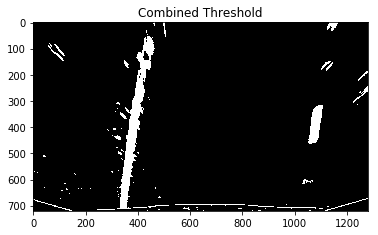

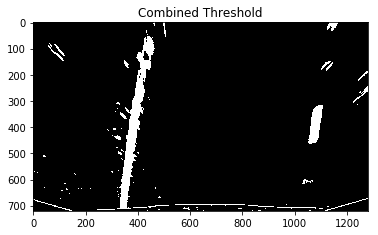

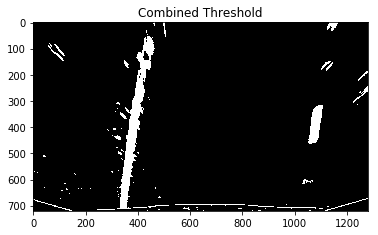

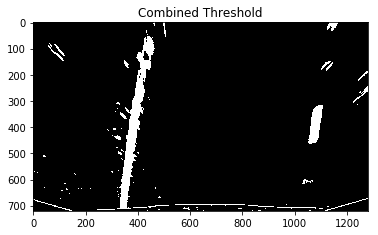

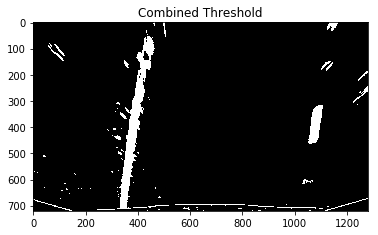

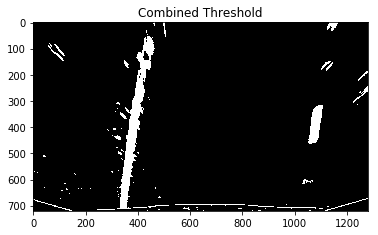

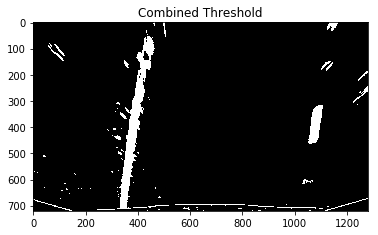

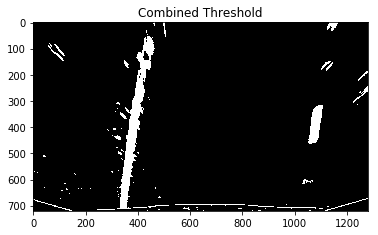

NameError: name 'cvtColor' is not defined

In [41]:
threshold_Images=[]
# Apply each of the thresholding functions
for Apicture in perspect_Image:
    combined = combined_threshold(Apicture)
    threshold_Images.append(combined)
    plt.imshow(combined, cmap = 'gray')
    plt.title('Combined Threshold')
    plt.show()   
plt.imsave('output_images/4', combined)

Step 5 - Sliding Window, Fit Polynomial, and Visualization

In [201]:
def Sliding_Polyfit_Window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = 255*np.dstack((binary_warped, binary_warped, binary_warped)).astype(np.uint8)
    window_img = np.zeros_like(out_img).astype(np.uint8)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
 
   
  
    
    return out_img, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty

    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    #plt.title('Fitted Lanes')
    #plt.show()

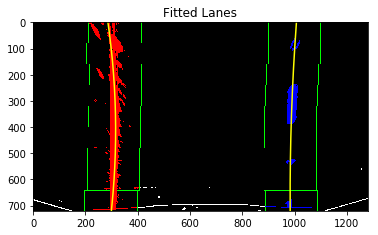

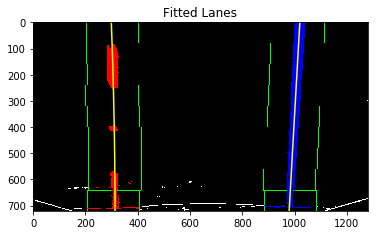

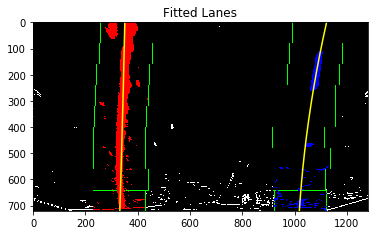

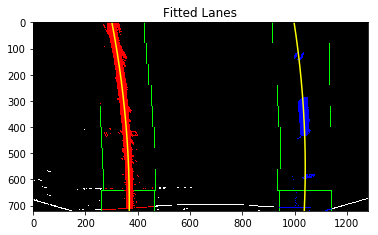

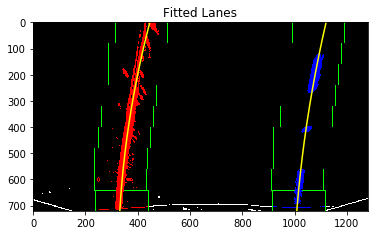

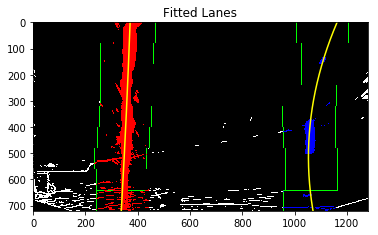

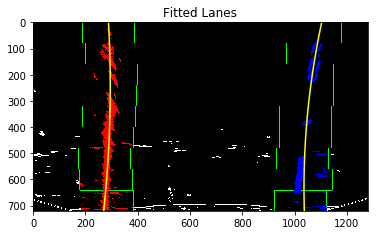

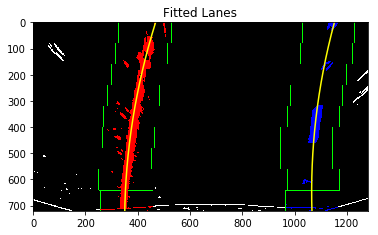

In [228]:
PolyData = []
for binary_warped in threshold_Images:
    output, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty = Sliding_Polyfit_Window(binary_warped)
    PolyData.append([ploty, left_fitx, right_fitx])

    output[lefty, leftx] = [255, 0, 0]
    output[righty, rightx] = [0, 0, 255]
    #result = cv2.addWeighted(out_img, 1, windows_img, 0.3, 0)
    plt.imshow(output)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.title('Fitted Lanes')
    plt.show()
    
    
plt.imsave('output_images/5', output)

Step 6 - Final Image Display

In [204]:
def Final_Image(dataImage, ploty, left_fitx, right_fitx, inverse_Matrix, undistorted_Image):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(dataImage).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, inverse_Matrix, (undistorted_Image.shape[1], undistorted_Image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undistorted_Image, 1, newwarp, 0.3, 0)
        
        return result

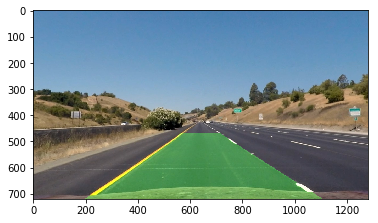

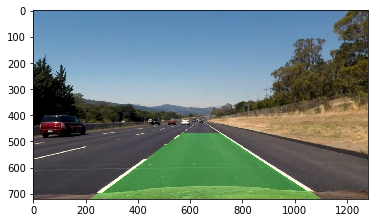

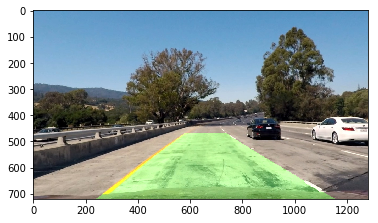

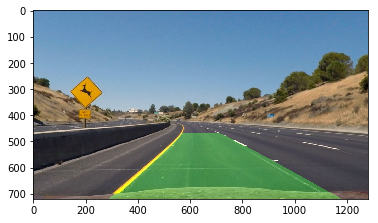

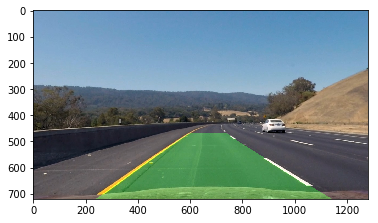

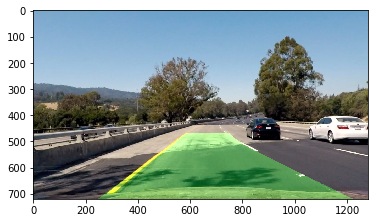

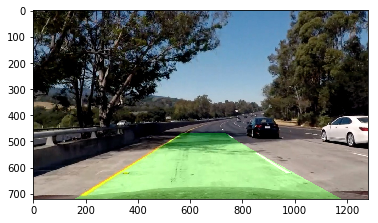

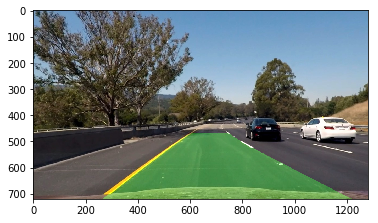

In [229]:
count = 0
while count < len(threshold_Images):
    #Current polyfit for frame
    ploty = PolyData[count][0] 
    left_fitx = PolyData[count][1] 
    right_fitx = PolyData[count][2]
    pic = threshold_Images[count]
    result = Final_Image(pic, ploty, left_fitx, right_fitx, Minv, Undistorted[count])
    plt.imshow(result)
    plt.show()
    count += 1
    
    
plt.imsave('output_images/6', result)

Step 7 - Build Pipeline 

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [210]:
def pipeline(theImage):
    # Grayscale the image called "image"
    #Correct_Image = cv2.cvtColor(theImage,cv2.COLOR_BGR2RGB)

    #Define kernal size 
    kernal_size = 7 #Kernal size has to be an odd number!

    #Use camera calibration coefficients, obtained prior
    #Undistort Image matrix is called "cal_matrix"
    # distortion called "distort"
    cal_matrix, distort = camera_cal(theImage, objpoints, imgpoints)
    
    #Undistort the image presented
    undistort = cal_undistort(theImage, cal_matrix, distort)
    
    #Change the perspective of the image
    warpedImage, Minv = warp(undistort)
        
    #Perform Threshold to Identify the Lane lines
    completeThreshold = combined_threshold(warpedImage, kernal_size)
    
    #Utilize a sliding window w/ error tolerance to track lane lines
    #Also create a polyfill region to indicate the region that we can drive in on the image
    output, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty = Sliding_Polyfit_Window(completeThreshold)
    
        
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_radius = (left_curverad + right_curverad) / 2
    avg_radius_output = round(avg_radius,3)
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    #Calculation of the lane center offset
    image_center = undistort.shape[1] / 2
    #Lane center in image
    lane_center = (left_fitx[710] + right_fitx[710]) /2
    #offset differencem that implies how far car is off from lane center
    #Positive indicates that the car is left of center and needs to move right
    #Negative indicates that the car is right of center and needs to move left
    Difference = round((lane_center - image_center)* xm_per_pix, 3)
    
    #Smoothing code 
    # If a lane was detected or not, then store the coefficients from polyfit to array
    # Append the lastest value to array remove oldest values, so there is always only n stored values
    #utilize the polyfit data over like n frames to come up with a smoothed polyfit curve
    # If the lane was not detected then pass the polyfit average to the output
    # If the lane was dected then check to see if the smoothed curve produces a small difference to center 
    # If either previous case is true pass these new polyfit parameters to the Finished_Image instead
    # Otherwise pass old values to the Finished_Image
    
    #Create Final Image with Polyfill lane and radius of curvature
    Finished_Image = Final_Image(completeThreshold, ploty = ploty,left_fitx = left_fitx,right_fitx = right_fitx,                                 inverse_Matrix = Minv, undistorted_Image = undistort)
    #vertices parameter for region of interest selection
    #imshape = image.shape
    #verticies for region of interest
    #vertices = np.array([[(0,imshape[0]),(450, 325), (490, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    #Limit the ouput of the hough transform to only the lanes needed, exclude everything else.
    #selRegion = region_of_interest(cannyImg,vertices)
    str1 = 'Radius of Curve: ' + str(avg_radius_output) +'m'
    str2 = 'Center Offset: ' + str(Difference) +'m'
    partial = cv2.putText(Finished_Image, text = str1, org = (5,50), fontFace = 1, fontScale = 3, color = (0,0,0), thickness = 5)
    return cv2.putText(partial, text = str2, org = (5,100), fontFace = 1, fontScale = 3, color = (0,0,0), thickness = 5)


Step 8 - Process Video

In [207]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [211]:
def process_image(frame):
    # NOTE: The output you return should be a lane processed video
    result = pipeline(frame)

    return result

In [214]:
Lines_output = 'video output/LaneLines.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip('project_video.mp4').subclip(20,25)
clip1 = VideoFileClip('project_video.mp4')
processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(Lines_output, audio=False)

[MoviePy] >>>> Building video video output/LaneLines.mp4
[MoviePy] Writing video video output/LaneLines.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:47:52<00:04,  4.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video output/LaneLines.mp4 

Wall time: 1h 47min 56s


In [215]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(Lines_output))

Extra Stuff (DO NOT RUN, this is extra stuff I might implement in the future!)

In [95]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))